In [ ]:
!pip install tensorflow
!pip install opencv-python

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf

In [ ]:
from google.colab import drive,files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Dataset-20250702.zip'

Archive:  /content/gdrive/MyDrive/Dataset-20250702.zip
  inflating: resized_224.zip         


In [ ]:
!unzip '/content/resized_224.zip'

Archive:  /content/resized_224.zip
   creating: resized_224/
  inflating: __MACOSX/._resized_224  
   creating: resized_224/test/
  inflating: __MACOSX/resized_224/._test  
   creating: resized_224/train/
  inflating: __MACOSX/resized_224/._train  
   creating: resized_224/validation/
  inflating: __MACOSX/resized_224/._validation  
   creating: resized_224/test/Cardiomegaly/
  inflating: __MACOSX/resized_224/test/._Cardiomegaly  
   creating: resized_224/test/No Finding/
  inflating: __MACOSX/resized_224/test/._No Finding  
   creating: resized_224/train/Cardiomegaly/
  inflating: __MACOSX/resized_224/train/._Cardiomegaly  
   creating: resized_224/train/No Finding/
  inflating: __MACOSX/resized_224/train/._No Finding  
   creating: resized_224/validation/Cardiomegaly/
  inflating: __MACOSX/resized_224/validation/._Cardiomegaly  
   creating: resized_224/validation/No Finding/
  inflating: __MACOSX/resized_224/validation/._No Finding  
  inflating: resized_224/test/Cardiomegaly/8946-5

In [ ]:
BASE_DIR = "/content/resized_224"
CATEGORIES = ["Cardiomegaly", "No Finding"]
random_seed = 42

fpath = f"{BASE_DIR}/train"
categories = os.listdir(fpath)
print("List of categories = ", categories)
print("No. of categories = ", len(categories))

List of categories =  ['Cardiomegaly', 'No Finding']
No. of categories =  2


In [ ]:
def load_dataset(dataset_type):
    dataset_path = Path(BASE_DIR) / dataset_type
    images, labels = [], []

    for class_idx, class_name in enumerate(CATEGORIES):
        class_path = dataset_path / class_name
        if not class_path.exists():
            raise ValueError(f"Missing directory: {class_path}")

        for img_file in class_path.glob("*"):
            img = cv2.imread(str(img_file))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(img).resize((224, 224))
                images.append(np.array(img))
                labels.append(class_idx)

    return np.array(images), np.array(labels)

x_train, y_train = load_dataset("train")
x_val, y_val = load_dataset("validation")
x_test, y_test = load_dataset("test")

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

for (x, y) in [(x_train, y_train), (x_val, y_val), (x_test, y_test)]:
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x[:] = x[indices]
    y[:] = y[indices]

In [ ]:
def create_pipeline(x, y, augment=False):
    y = np.expand_dims(y, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.cache()
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = create_pipeline(x_train, y_train, augment=True)
val_ds = create_pipeline(x_val, y_val)
test_ds = create_pipeline(x_test, y_test)


Training samples:


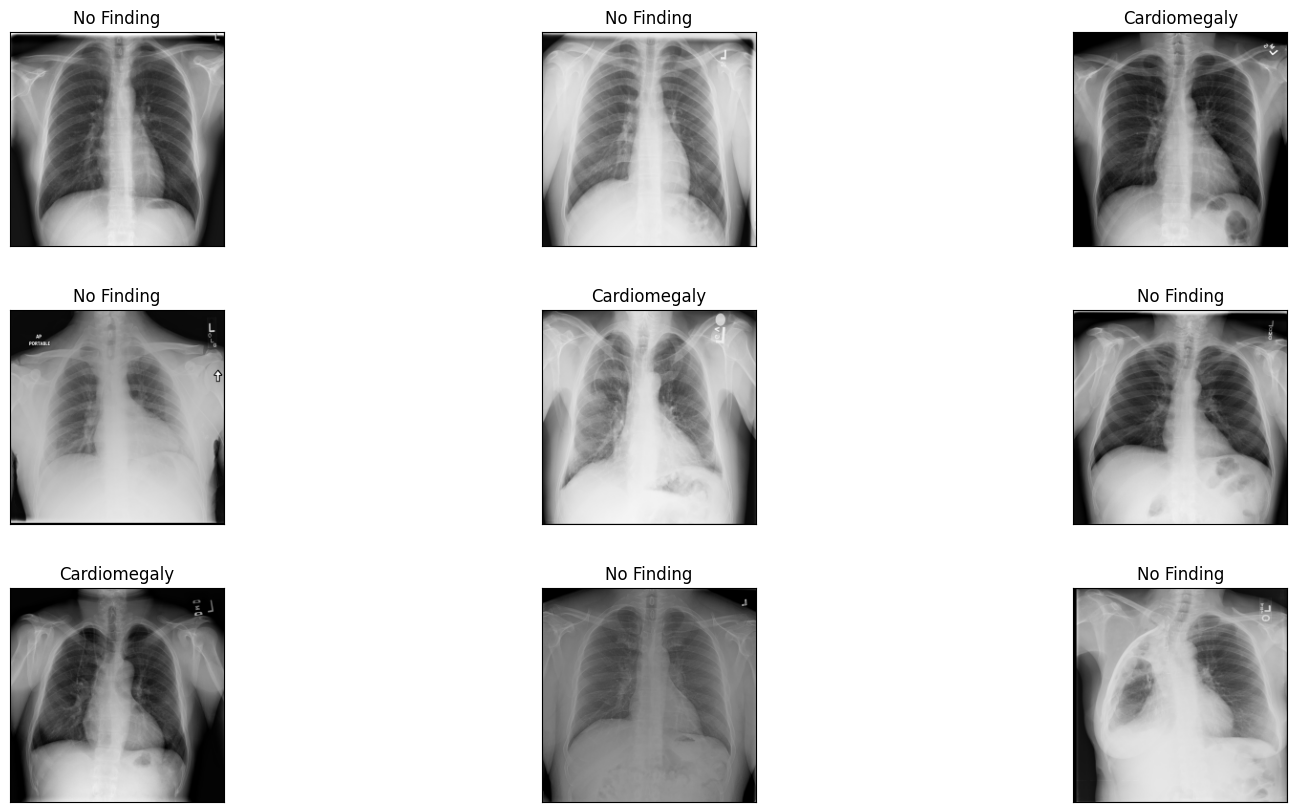


Validation samples:


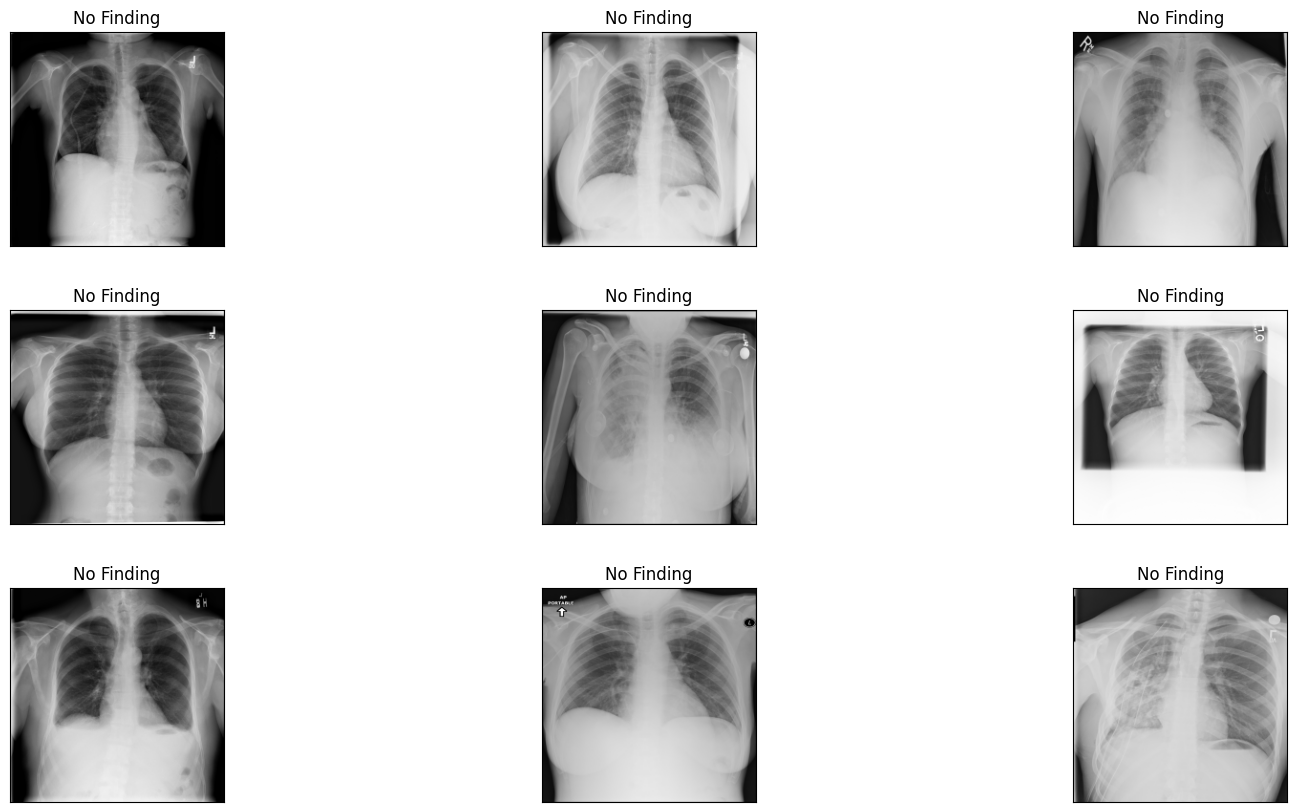


Test samples:


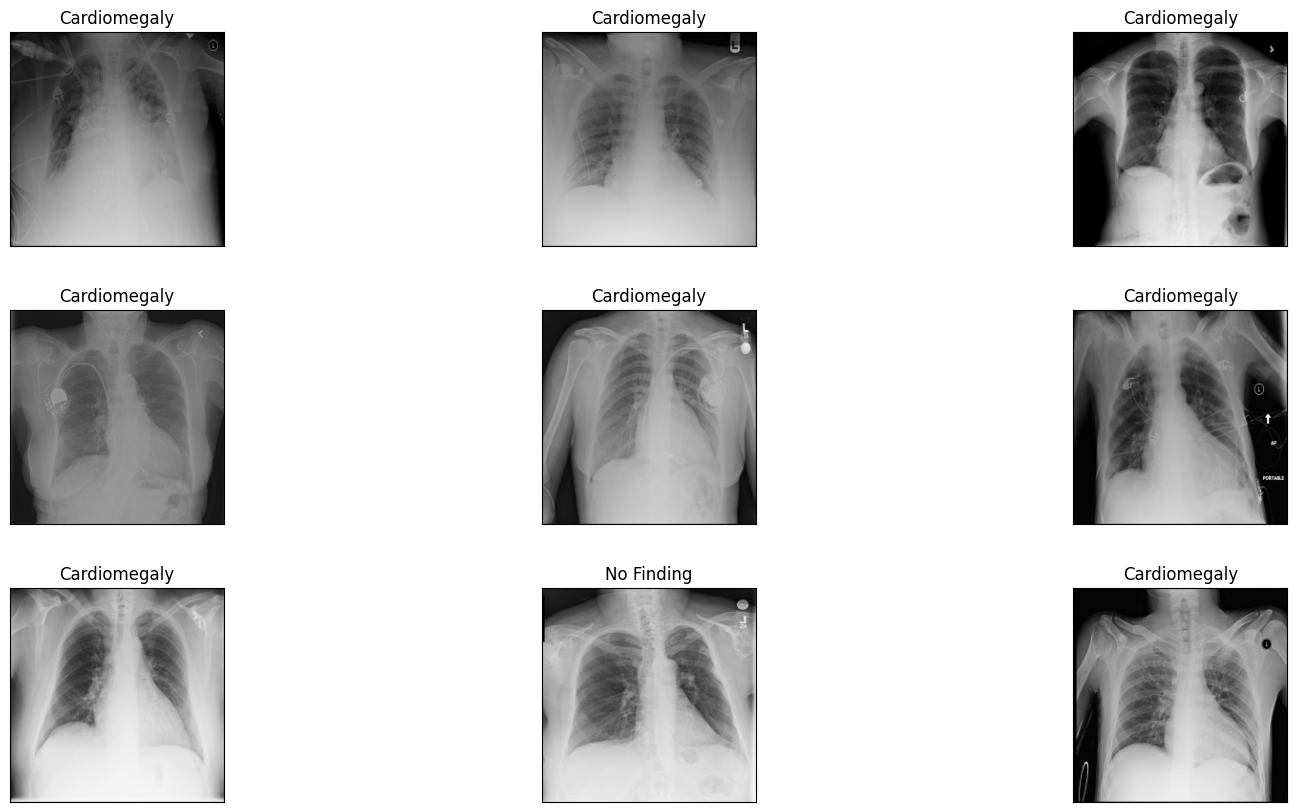

In [ ]:
def display_rand_images(images, labels, label_map=None):
    plt.figure(1, figsize=(19, 10))
    n = 0
    for i in range(9):
        n += 1
        r = np.random.randint(0, images.shape[0], 1)
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.imshow(images[r[0]])
        if label_map:
            title = label_map[labels[r[0]]]
        else:
            title = str(labels[r[0]])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.show()

label_map = {0: 'Cardiomegaly', 1: 'No Finding'}

print("\nTraining samples:")
display_rand_images(x_train, y_train, label_map)
print("\nValidation samples:")
display_rand_images(x_val, y_val, label_map)
print("\nTest samples:")
display_rand_images(x_test, y_test, label_map)

In [ ]:
random_seed = 42
np.random.seed(random_seed)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score

mixed_precision.set_global_policy("mixed_float16")
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
WARMUP_EPOCHS = 10
FT_EPOCHS = 50

def ensure_0_255(x_list):
    for i, x in enumerate(x_list):
        if np.nanmax(x) <= 1.0:
            x_list[i] = (x * 255.0).astype(np.float32)
        else:
            x_list[i] = x.astype(np.float32)
    return x_list

x_train, x_val, x_test = ensure_0_255([x_train, x_val, x_test])

def preprocess_for_efficientnet(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, tf.cast(label, tf.float32)

augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augmentation")

def augment_image(image, label):
    image = augmentation(image, training=True)
    return image, label

def make_dataset(x, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(lambda a, b: (tf.cast(a, tf.float32), b), num_parallel_calls=AUTOTUNE)
    ds = ds.map(preprocess_for_efficientnet, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, training=True)
val_ds   = make_dataset(x_val, y_val, training=False)
test_ds  = make_dataset(x_test, y_test, training=False)

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling=None)
base_model.trainable = False

inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
model = models.Model(inputs=inputs, outputs=outputs)

callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_auc", mode="max", verbose=1),
    EarlyStopping(monitor="val_auc", patience=7, restore_best_weights=True, mode="max", verbose=1),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=WARMUP_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

for layer in base_model.layers[-120:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks_ft = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_auc", mode="max", verbose=1),
    EarlyStopping(monitor="val_auc", patience=10, restore_best_weights=True, mode="max", verbose=1),
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    callbacks=callbacks_ft,
    verbose=1
)

model.load_weights("best_model.keras")

y_pred_proba = model.predict(val_ds).ravel()
thresholds = np.linspace(0.1, 0.9, 81)
accs = [accuracy_score(y_val, y_pred_proba > t) for t in thresholds]
best_t = thresholds[np.argmax(accs)]
print(f"Best threshold on validation: {best_t:.2f}, Val acc: {max(accs):.4f}")

y_test_pred_proba = model.predict(test_ds).ravel()
y_test_pred = (y_test_pred_proba > best_t).astype(int)
final_acc = accuracy_score(y_test, y_test_pred)
test_loss, test_acc, test_auc = model.evaluate(test_ds, verbose=0)

print(f"Final Test — acc: {final_acc:.4f}, auc: {test_auc:.4f}, loss: {test_loss:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4739 - auc: 0.4738 - loss: 0.8494
Epoch 1: val_auc improved from -inf to 0.54890, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 609ms/step - accuracy: 0.4743 - auc: 0.4743 - loss: 0.8489 - val_accuracy: 0.5339 - val_auc: 0.5489 - val_loss: 0.6910
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5367 - auc: 0.5567 - loss: 0.7659
Epoch 2: val_auc improved from 0.54890 to 0.61290, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - accuracy: 0.5372 - auc: 0.5571 - loss: 0.7657 - val_accuracy: 0.5521 - val_auc: 0.6129 - val_loss: 0.6823
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5709 - auc: 0.5939 - loss: 0.7395
Epoch 3: val_auc improved from 0.61290 to 0.63862, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - accuracy: 0.5708 - auc: 0.5938 - loss: 0.7395 - val_acc

Using middle Conv2D layer for Grad-CAM: block5a_expand_conv


/tmp/ipython-input-62352010.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_scalar = float(probs)  # convert to Python float


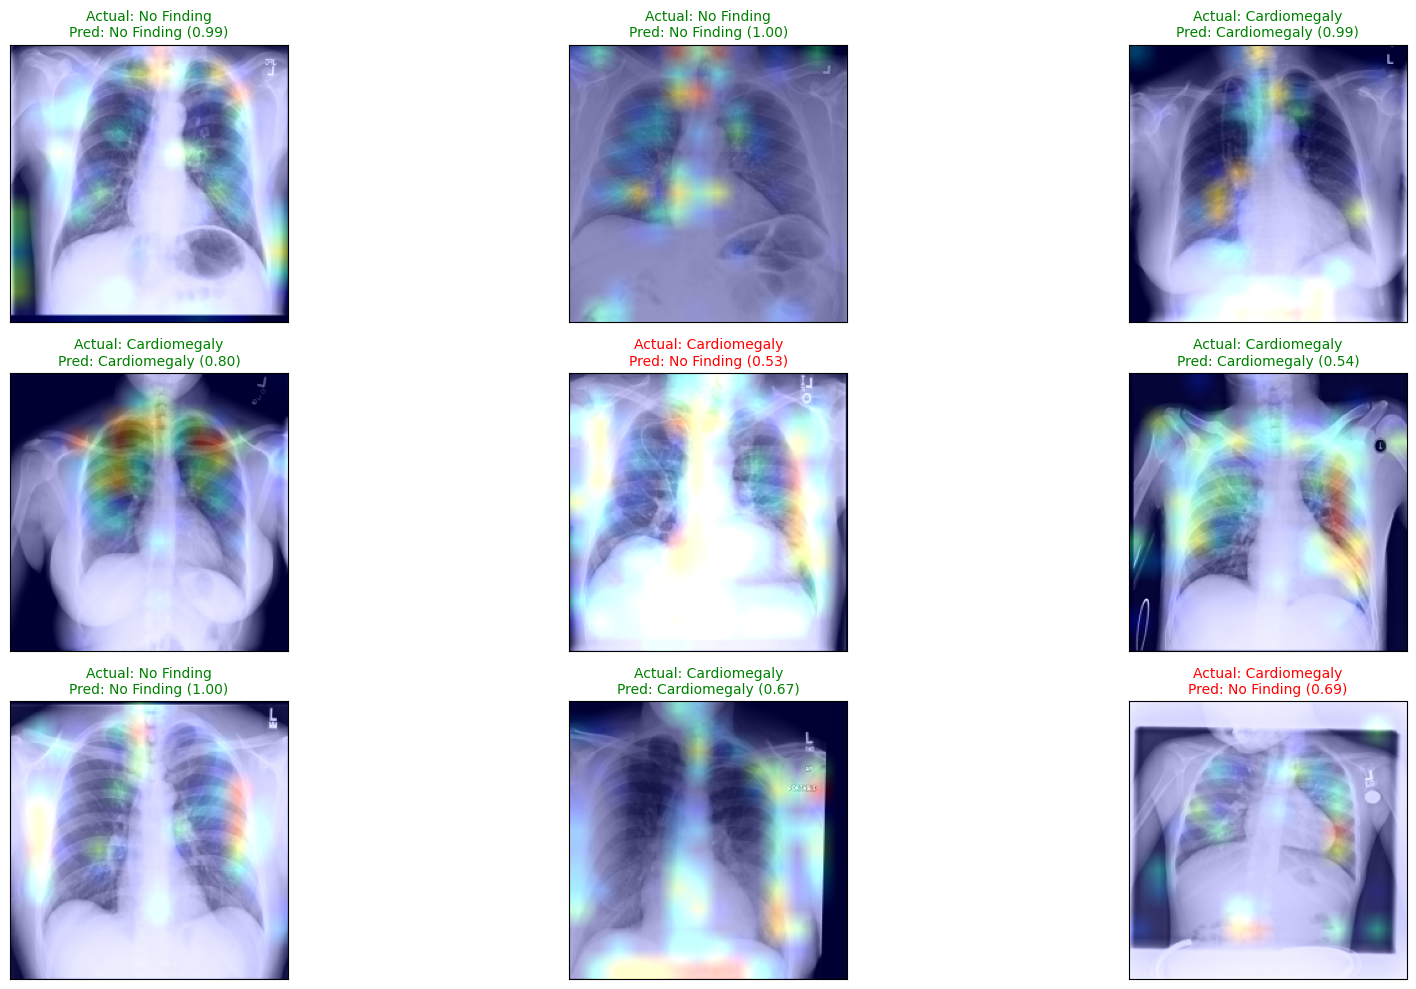

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def get_middle_conv_layer(model):
    """Return the name of a middle Conv2D layer in the model."""
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    mid_idx = len(conv_layers) // 2
    return conv_layers[mid_idx]

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.image.resize(
        np.expand_dims(jet_heatmap, 0),
        (img.shape[0], img.shape[1])
    ).numpy()[0]

    superimposed_img = jet_heatmap * alpha + img / 255.0
    return np.clip(superimposed_img, 0, 1)



plt.figure(figsize=(19, 10))
label_map = {0: 'Cardiomegaly', 1: 'No Finding'}

middle_conv_layer = get_middle_conv_layer(model)
print("Using middle Conv2D layer for Grad-CAM:", middle_conv_layer)

for i in range(9):
    r = np.random.randint(0, x_test.shape[0])
    img = x_test[r]
    actual_class = int(y_test[r])
    actual_label = label_map[actual_class]

    img_array = tf.expand_dims(
        tf.keras.applications.efficientnet.preprocess_input(
            tf.image.resize(img, IMG_SIZE)
        ),
        axis=0
    )

    probs = model.predict(img_array, verbose=0)
    prob_scalar = float(probs)
    pred_class = 1 if prob_scalar > 0.5 else 0
    pred_label = label_map[pred_class]
    confidence = prob_scalar if pred_class == 1 else 1 - prob_scalar

    heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name=middle_conv_layer)
    gradcam_img = overlay_gradcam(img, heatmap)

    color = "green" if pred_class == actual_class else "red"

    plt.subplot(3, 3, i+1)
    plt.imshow(gradcam_img)
    plt.title(
        f"Actual: {actual_label}\nPred: {pred_label} ({confidence:.2f})",
        color=color,
        fontsize=10
    )
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc, test_auc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

y_pred_probs = model.predict(test_ds).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = y_test

print("Average probabilities for class Cardiomegaly:", np.mean(1 - y_pred_probs))
print("Average probabilities for class No Finding:", np.mean(y_pred_probs))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
auc_score = auc(fpr, tpr)

print("\n=== Basic Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC (Overall): {auc_score:.4f}")
print("Confusion Matrix:\n", confusion)

TN, FP, FN, TP = confusion.ravel()
recall_cardiomegaly = TP / (TP + FN) if (TP + FN) > 0 else 0
recall_no_finding = TN / (TN + FP) if (TN + FP) > 0 else 0
specificity_cardiomegaly = TN / (TN + FP) if (TN + FP) > 0 else 0
specificity_no_finding = TP / (TP + FN) if (TP + FN) > 0 else 0
balanced_acc = balanced_accuracy_score(y_true, y_pred)

fpr0, tpr0, _ = roc_curve(y_true, 1 - y_pred_probs)
auc_cardiomegaly = auc(fpr0, tpr0)
fpr1, tpr1, _ = roc_curve(y_true, y_pred_probs)
auc_no_finding = auc(fpr1, tpr1)

print("\n=== Extended Metrics ===")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Sensitivity (Cardiomegaly): {recall_cardiomegaly:.4f}")
print(f"Specificity (Cardiomegaly): {specificity_cardiomegaly:.4f}")
print(f"Sensitivity (No Finding): {recall_no_finding:.4f}")
print(f"Specificity (No Finding): {specificity_no_finding:.4f}")
print(f"ROC AUC (Cardiomegaly): {auc_cardiomegaly:.4f}")
print(f"ROC AUC (No Finding): {auc_no_finding:.4f}")

Test Loss: 0.4935
Test Accuracy: 0.8000
Test AUC: 0.8905
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Average probabilities for class Cardiomegaly: 0.43128064
Average probabilities for class No Finding: 0.5687194

=== Basic Metrics ===
Precision: 0.7586
Recall: 0.8800
F1 Score: 0.8148
AUC (Overall): 0.8920
Confusion Matrix:
 [[72 28]
 [12 88]]

=== Extended Metrics ===
Balanced Accuracy: 0.8000
Sensitivity (Cardiomegaly): 0.8800
Specificity (Cardiomegaly): 0.7200
Sensitivity (No Finding): 0.7200
Specificity (No Finding): 0.8800
ROC AUC (Cardiomegaly): 0.1080
ROC AUC (No Finding): 0.8920


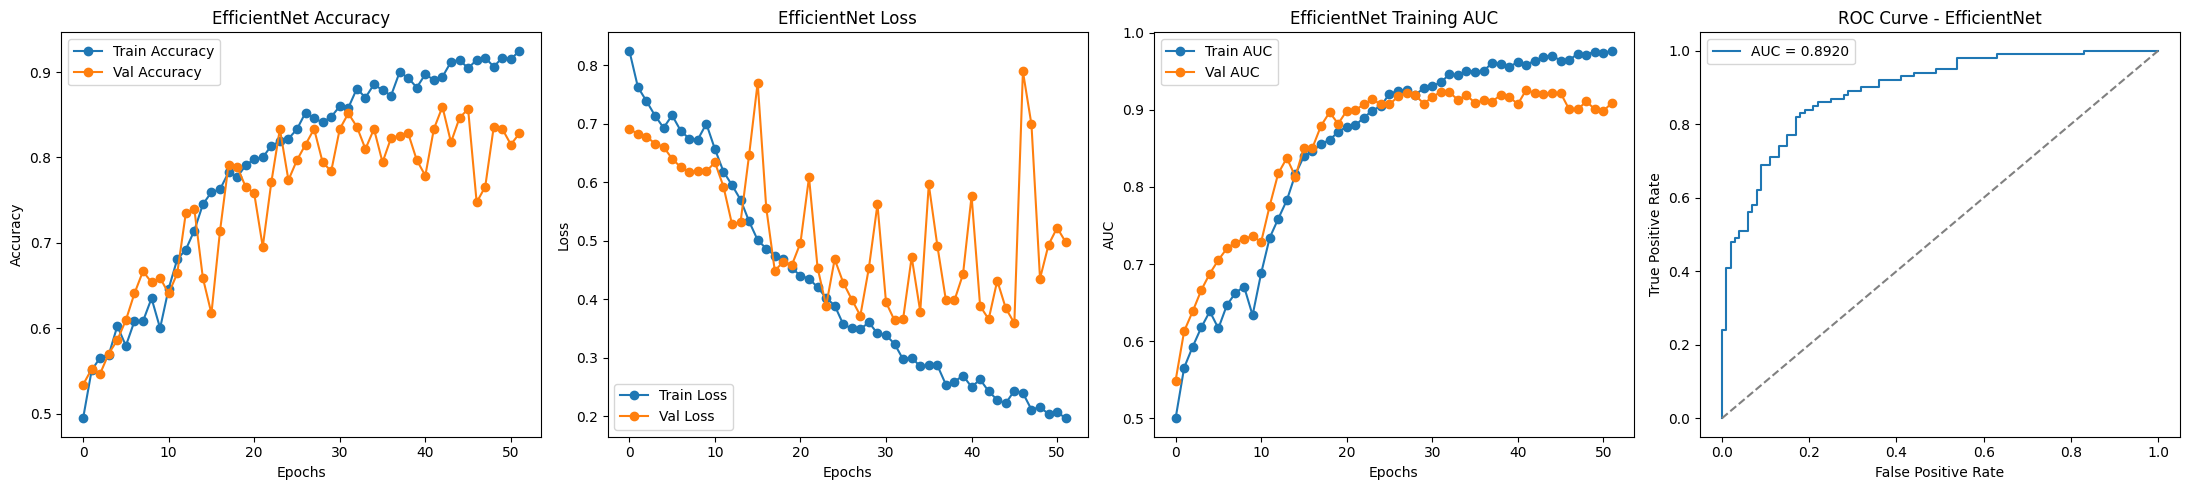

In [ ]:
plt.figure(figsize=(22,5))

plt.subplot(1,4,1)
plt.plot(history_combined['accuracy'], 'o-', label='Train Accuracy')
plt.plot(history_combined['val_accuracy'], 'o-', label='Val Accuracy')
plt.title('EfficientNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,4,2)
plt.plot(history_combined['loss'], 'o-', label='Train Loss')
plt.plot(history_combined['val_loss'], 'o-', label='Val Loss')
plt.title('EfficientNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,4,3)
plt.plot(history_combined['auc'], 'o-', label='Train AUC')
plt.plot(history_combined['val_auc'], 'o-', label='Val AUC')
plt.title('EfficientNet Training AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.subplot(1,4,4)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - EfficientNet")
plt.legend()

plt.tight_layout()
plt.show()


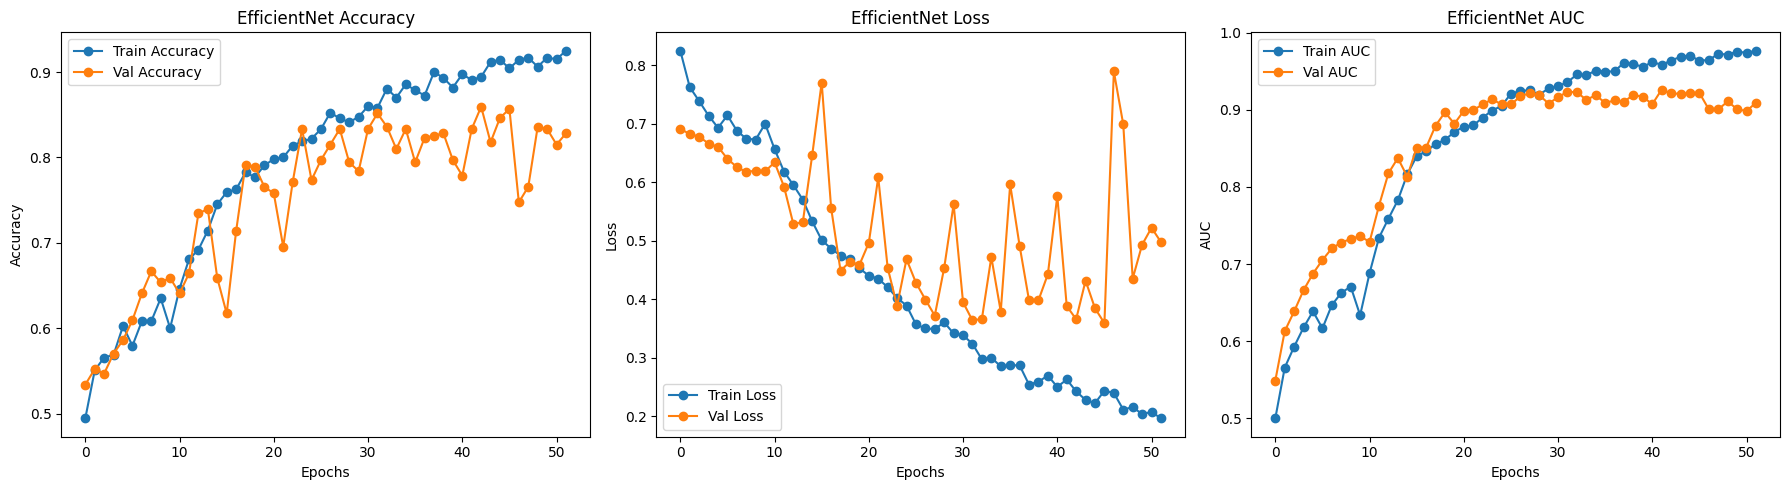

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(history_combined['accuracy'], 'o-', label='Train Accuracy')
plt.plot(history_combined['val_accuracy'], 'o-', label='Val Accuracy')
plt.title('EfficientNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history_combined['loss'], 'o-', label='Train Loss')
plt.plot(history_combined['val_loss'], 'o-', label='Val Loss')
plt.title('EfficientNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history_combined['auc'], 'o-', label='Train AUC')
plt.plot(history_combined['val_auc'], 'o-', label='Val AUC')
plt.title('EfficientNet AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


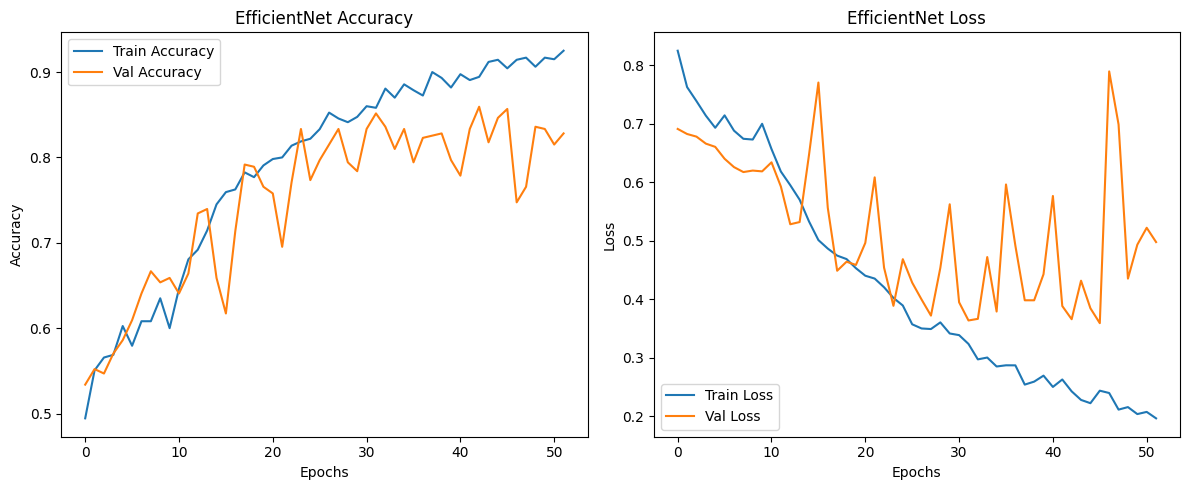

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_combined['accuracy'], label='Train Accuracy')
plt.plot(history_combined['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_combined['loss'], label='Train Loss')
plt.plot(history_combined['val_loss'], label='Val Loss')
plt.title('EfficientNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

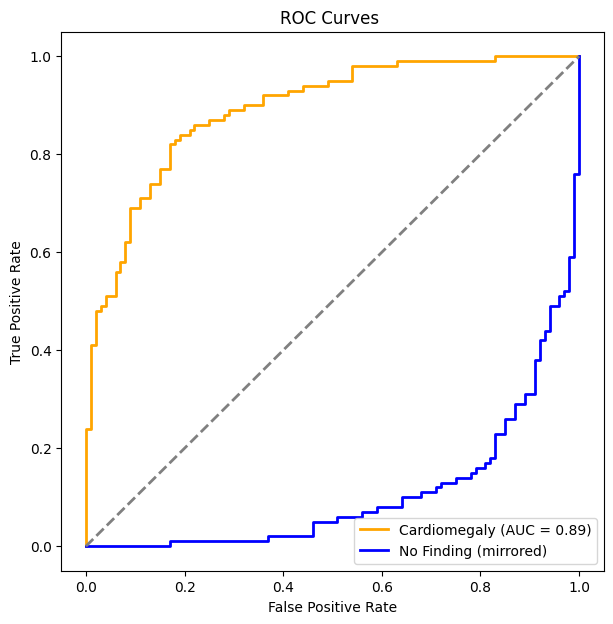

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(x_test, verbose=0).ravel()
y_test_bin = y_test.ravel()

fpr_pos, tpr_pos, _ = roc_curve(y_test_bin, y_pred_probs)
auc_pos = auc(fpr_pos, tpr_pos)


fpr_neg_mirror = 1 - fpr_pos
tpr_neg_mirror = 1 - tpr_pos
auc_neg_mirror = auc(fpr_neg_mirror, tpr_neg_mirror)

plt.figure(figsize=(7,7))
plt.plot(fpr_pos, tpr_pos, color="orange", lw=2, label=f"Cardiomegaly (AUC = {auc_pos:.2f})")
plt.plot(fpr_neg_mirror, tpr_neg_mirror, color="blue", lw=2, label=f"No Finding (mirrored)")
plt.plot([0,1], [0,1], color="grey", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves ")
plt.legend(loc="lower right")
plt.show()


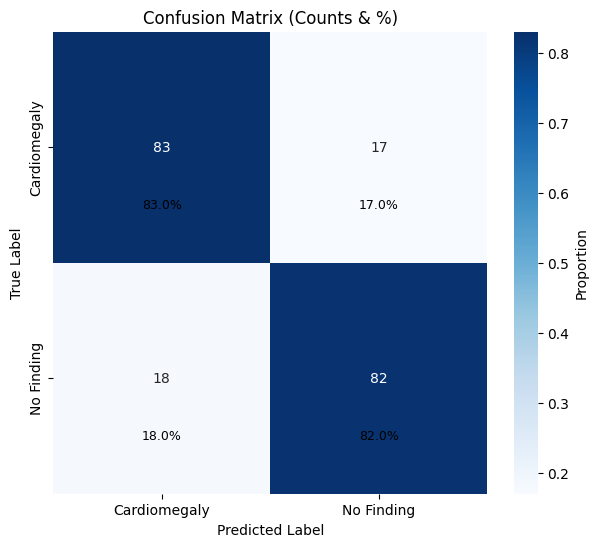

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(y_test, y_test_pred)

conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]

labels = ['Cardiomegaly', 'No Finding']

plt.figure(figsize=(7, 6))

sns.heatmap(
    conf_matrix_norm,
    annot=conf_matrix,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Proportion'}
)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, i + 0.75,
            f"{conf_matrix_norm[i, j]*100:.1f}%",
            ha='center', va='center',
            color='black', fontsize=9
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Counts & %)')
plt.show()
